In [105]:
import copy
import math
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
import matplotlib.patches as patches
import numpy as np
from collections import defaultdict
import pandas as pd

In [106]:
def get_k_furthest_nodes(graph, node_list, start_node,k):
    # Create a subgraph with the given node list
    
    subgraph = graph.subgraph(node_list).copy()
    
    # Ensure the start_node is in the subgraph
    if start_node not in subgraph:
        raise ValueError("Start node is not in the subgraph")
    
    # Calculate shortest path lengths from the start node to all other nodes
    path_lengths = nx.single_source_shortest_path_length(subgraph, start_node)
    
    # Sort nodes by their distance from the start node (furthest first)
    sorted_nodes = sorted(path_lengths.items(), key=lambda x: x[1], reverse=True)
    
    # Get the three furthest nodes
    furthest_nodes = [node for node, distance in sorted_nodes[:k]]
    
    return  furthest_nodes

In [107]:
def best_sensors_dynamic_for_path(G1, path,node_mapping,sensor_mapping,sensor_edge_mapping,weights):
    
    sensor_path=[]
    sensor_and_coverage=[]
    for u,v in zip(path,path[1:]):
        edge=(u,v)
        available_sensors=set()
        for sensor,edges in sensor_edge_mapping.items():
            if edge in edges or ((v,u) in edges):
                available_sensors.add(sensor)
        available_sensors=list(available_sensors)
        sensor_path.append(available_sensors)
        sensor_and_coverage.append((available_sensors,edge))
    #print('Sensor path:',sensor_and_coverage)
    '''for u,v,id in zip(sensor_path,sensor_path[1:],range(len(sensor_path))):
        common=set(v).intersection(set(u))
        if common:
            hold=[]
            for sensor in u:
                if sensor not in common:
                    hold.append(sensor)
            sensor_path[id]=hold
    '''
            
    sensor_graph=nx.Graph()
    for u,v in zip(sensor_path,sensor_path[1:]):
      #  if not set(u).intersection(v):
            for sensor1 in u:
                for sensor2 in v:
                    if sensor1 != sensor2 :
                        sensor_graph.add_edge(sensor1,sensor2)
    #nx.draw(sensor_graph, with_labels=True, font_weight='bold')            
    
    #node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    #sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    entry_sensors=set()
    target_sensors=set()
    for sensor in node_mapping[path[0]]:
        if sensor in sensor_graph.nodes():
            entry_sensors.add(sensor)
    for sensor in node_mapping[path[-1]]:
        if sensor in sensor_graph.nodes():
            target_sensors.add(sensor)
    initial_entry=copy.deepcopy(entry_sensors)
    initial_targets=copy.deepcopy(target_sensors)
    
    sensor_costs=1000000
    path=[]
    for entry in initial_entry:
        for target in initial_targets:
            if entry != target:
                cost,sensor_path=best_sensors_dynamic(G1,sensor_graph,entry,target,sensor_mapping,sensor_only_distance,weights)
                if cost<sensor_costs:
                    sensor_costs=cost
                    path=sensor_path
    
    
    return sensor_costs,path

In [108]:
def best_sensors_dynamic(G1,G2, start, end,sensor_mapping,distance_func,weights):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)

    
    
    subgraph2=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == end:
            to_be_removed_sensors.append(sensor)
    distances = defaultdict(lambda: float('inf'))
    predecessors = {}
    distances[end] = 0
    queue = [end]
    G=subgraph2.copy()
    while queue:
        current = queue.pop(0)
        
        for neighbor in G2.neighbors(current):
            edge_distance = distance_func( neighbor,to_be_removed_sensors,weights)
            new_distance = distances[current] + edge_distance
            
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current
                queue.append(neighbor)
    
    # Reconstruct the path
    path = []
    current = start
    while current != end:
        path.append(current)
        if current not in predecessors:
            return 10000, [0]  # No path exists
        current = predecessors[current]
    path.append(end)
    
    return distances[start], path


def sensor_only_distance(sensor2,excluded_sensors,weights):
    norm=sum(weights)
    share_decep_sensor=0
    if sensor2  in excluded_sensors:
        share_decep_sensor=100
    extra_sensor_cost=2
    return  ((norm/weights[2])*extra_sensor_cost)+ ((norm/weights[3])*share_decep_sensor)

In [109]:

def shortest_path_dynamic(G1,G2, start, end,sensor_mapping,sensor_edge_mapping ,distance_func,weights):
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    entry=copy.copy(start)
    target_id=copy.copy(end)
    
    subgraph=G1.copy()
    G=subgraph.copy()
    subgraph2=G2.copy()
    to_be_removed=[]
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == end:
            to_be_removed_sensors.append(sensor)
    for node in list(subgraph.nodes):
        if (node != entry and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    distances = defaultdict(lambda: float('inf'))
    predecessors = {}
    distances[end] = 0
    queue = [end]
    covered_sensors=set()
    
    while queue:
        current = queue.pop(0)
        
        for neighbor in G.neighbors(current):
            edge_distance = distance_func(G, current, neighbor,to_be_removed,to_be_removed_sensors,sensor_edge_mapping,weights,covered_sensors)
            new_distance = distances[current] + edge_distance
            
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current
                queue.append(neighbor)
    
    # Reconstruct the path
    path = []
    current = start
    while current != end:
        path.append(current)
        if current not in predecessors:
            return float('inf'), None  # No path exists
        current = predecessors[current]
    path.append(end)
    #print('Path valid',path)
    return distances[start], path

def custom_distance(G, node1, node2,excluded_nodes,excluded_sensors,sensor_edge_mapping,weights,covered_sensors):
    norm=sum(weights)
    decep_phys=0
    if node2  in excluded_nodes:
        decep_phys=1000
    extra_node_cost=2
    share_decep_sensor=10
    covering_sensors=set()
    new_sensors=0
    for sensor,mapping in sensor_edge_mapping.items():
        if (node1,node2) in mapping or (node2,node1) in mapping:
            covering_sensors.add(sensor)
        if sensor not in covered_sensors:
            covering_sensors.add(sensor)
            new_sensors+=10
    if any([True for sensor in covering_sensors if sensor not in excluded_sensors]):
        share_decep_sensor=0    
   
    base_weight = G[node1][node2].get('weight', 1)
    return (base_weight*(norm/weights[0])) + ((norm/weights[1])*extra_node_cost)+ ((norm/weights[2])*new_sensors) +((norm/weights[3])*decep_phys) + ((norm/weights[4])*share_decep_sensor)

def physical_only_distance(G, node1, node2,excluded_nodes,excluded_sensors,sensor_edge_mapping,weights,covered_sensors):
    norm=sum(weights)
    decep_phys=0
    if node2  in excluded_nodes:
        decep_phys=1000
    extra_node_cost=2 
    base_weight = G[node1][node2].get('weight', 1)
    return (base_weight*(norm/weights[0])) + ((norm/weights[1])*extra_node_cost)+ ((norm/weights[3])*decep_phys)

In [110]:
def get_node_probabilities(G1):
    
    subgraph=G1.copy()
    node_probabilities={}
    costs={}
    max_prob_target = {}
    targets=[]
    for node in subgraph.nodes(data=True):
        if node[1].get('type')== 'target':
            targets.append(node[0])
    #print(targets)
    for node in subgraph.nodes:
        if node in targets:
            node_probabilities[node] = {node:1}
            max_prob_target[node]=(node,1)
        else:
            costs[node] = {target: nx.dijkstra_path_length(subgraph,node,target,weight='weight') for target in targets}
            #print(costs[node])
            total_cost = sum([1/costs[node][k] for k,v in costs[node].items()])
            #print(total_cost)
            node_probabilities[node] = {target: (1/cost) / total_cost for target, cost in costs[node].items()}
            #print(node_probabilities[node].items())
            #print(max(node_probabilities[node].items(), key=lambda x: x[1]))
            max_prob_target[node] = max(node_probabilities[node].items(), key=lambda x: x[1])
    return node_probabilities, max_prob_target,targets,costs

In [111]:
def calculate_sensor_probabilities(node_probabilities, sensor_mapping,all_targets):
    sensor_probabilities = {}
    max_target_per_sensor = {}

    for sensor_id, nodes in sensor_mapping.items():
        # Initialize a dictionary to store cumulative probabilities for each target
        target_probabilities = {target: 0 for target in all_targets}

        for node in nodes:
            if node in node_probabilities:
                for target, probability in node_probabilities[node].items():
                    '''for all_target in all_targets:
                        if all_target not in target_probabilities:
                            target_probabilities[target] = 0'''
                    target_probabilities[target] += probability

        # Normalize the probabilities so they sum to 1
        total_probability = sum(target_probabilities.values())
        if total_probability > 0:
            for target in target_probabilities:
                target_probabilities[target] /= total_probability

        # Store the cumulative probabilities for the sensor
        sensor_probabilities[sensor_id] = target_probabilities

        # Determine the target with the maximum probability for this sensor
        if target_probabilities:
            max_target = max(target_probabilities, key=target_probabilities.get)
            max_target_per_sensor[sensor_id] = max_target

    return sensor_probabilities, max_target_per_sensor


In [112]:
def farthest_nodes(graph, entry_node, num_targets):
    # Step 1: Calculate distances from the entry node to all other nodes
    distances = nx.single_source_shortest_path_length(graph, entry_node)
    
    # Step 2: Sort nodes by distance from entry node (farthest first)
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1], reverse=True)
    farthest_candidates = [node for node, dist in sorted_nodes]
    
    # Step 3: Select target nodes that are also far from each other
    selected_targets = []
    
    min_dist = nx.diameter(graph)
    while len(selected_targets) < num_targets+1:
        for candidate in farthest_candidates:
            # Check if the candidate is far enough from the already selected targets
            if all(nx.shortest_path_length(graph, candidate, target) >= min_dist for target in selected_targets):
                selected_targets.append(candidate)
        min_dist-=1
    if 0 in selected_targets:
        selected_targets.remove(0)
    return selected_targets

In [113]:
def create_physical_graph(n, p, num_targets,min_weight,max_weight):
    edges = combinations(range(n), 2)
    G = nx.path_graph(n)
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p >= 1:
        G= nx.complete_graph(n, create_using=G)
        for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = random.uniform(min_weight,max_weight)
        return G
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    #G=nx.barabasi_albert_graph(n,int(p*10))
    for u, v in G.edges():
        
            #G[u][v]['capacity'] = random.randint(-10,-1)
            G[u][v]['weight'] = float("{:.2f}".format(abs((u) - (v) )*random.uniform(min_weight,max_weight)))
    G.nodes[0]['type'] = 'entry'
    target_nodes=farthest_nodes(G,0,num_targets)[:num_targets]
    for t in target_nodes:
        G.nodes[t]['type'] = 'target'
    return G,target_nodes

In [114]:
def find_sensors(d, set1, set2):
    return [k for k, v in d.items() if set1 in v and set2 in v]

In [115]:
def filter_dict(d, allowed_list):
    return {k: v for k, v in d.items() if any(x not in [y for i, w in d.items() if i != k for y in w] and x in allowed_list for x in v)}

In [116]:
def get_nodes_within_distance(start_node, max_distance,graph,max_nodes_per_sensor):
    distances = nx.single_source_dijkstra_path_length(graph, start_node, cutoff=max_distance, weight='weight')
    #print(distances)
    
    return set(list(distances.keys())[:max_nodes_per_sensor])
def create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor):
    all_covered_nodes = set()
    init_rad=sensor_radius
    i=1
    b=1
    init_radius=sensor_radius
    init_sensors=num_sensors
    while set(all_covered_nodes) != set(Gp.nodes()):
        all_covered_nodes = set()
        C = {v: set() for v in Gp.nodes()}
        S = {s: set() for s in range(num_sensors)}
        senseo_edge_mapping={s: set() for s in range(num_sensors)}
        graph=Gp.copy()
        available_nodes = set(graph.nodes())
        to_keep=[random.choice(list(available_nodes))]
        centers=set()
        for sensor in range(num_sensors):
                     
           # print('Available',available_nodes)
            if not available_nodes:
                graph=Gp.copy()
                available_nodes=set([node for node in graph.nodes() if node not in centers])
                to_keep=available_nodes
                graph.remove_nodes_from(centers)
            start_node = random.choice(list(to_keep))
            centers.add(start_node)
            #print(graph.nodes())
            covered_nodes = get_nodes_within_distance(start_node, sensor_radius,graph,max_nodes_per_sensor)

                
            to_keep=get_k_furthest_nodes(graph,covered_nodes,start_node,inter_param)
            to_remove=[]
            for node in graph.nodes():
                if node in covered_nodes:
                    all_covered_nodes.add(node)
                    if node not in to_keep:
                        to_remove.append(node)
            
            S[sensor] = covered_nodes
            for node in covered_nodes:
                C[node].add(sensor)
            available_nodes -= covered_nodes
            graph.remove_nodes_from(to_remove)
            sing_cent=random.choice(list(to_keep))
            new_centers=sing_cent
            #get_nodes_within_distance(sing_cent, sensor_radius*0.7,graph,max_nodes_per_sensor)
            new_centers=[sing_cent]
                #get_k_furthest_nodes(graph,new_centers,sing_cent,inter_param))
            to_keep=new_centers
        #print(all_covered_nodes)
        if set(all_covered_nodes) != set(Gp.nodes()):
            sensor_radius+= 1
            i+=1
            if i >=10 :
                num_sensors+=1
                i=1
                b+=1
                if b>=2:
                    max_nodes_per_sensor+=1
                    sensor_radius=init_radius
                    num_sensors=init_sensors
                    
                
                #print(num_sensors)
    #print('Radius',sensor_radius)
    #S = {k: v for k, v in S.items() if len(v) > 1}
    C = {k: {item for item in v if item in S.keys()} for k, v in C.items()}
    #print('Number of sensors',len(S.keys()))
    
    senseo_edge_mapping={s: set() for s in range(num_sensors)}
    for s in S.keys():
        hold=set()
        for (j,k) in Gp.edges():
            #print((j,k))
            if (j in S[s]) and (k in S[s]):
                hold.add((j,k))
        #print(hold,s)
        senseo_edge_mapping[s]=hold
    
    edges_to_remove=[]
    for (u,v) in Gp.edges():
        covered=False
        for key,val in senseo_edge_mapping.items():
            if (u,v) in val  or (v,u):
                covered=True
                break
        if not covered:
            edges_to_remove.append((u,v))
    
    for e in edges_to_remove:
        Gp.remove_edge(e[0],e[1])
        Gp.remove_edge(e[1],e[0])
                
    return C, S,senseo_edge_mapping
def create_sensor_graph(S):
    Gs = nx.Graph()
    Gs.add_nodes_from(S.keys())
    for s1 in S:
        for s2 in S:
            if s1 != s2:
                if S[s1].intersection(S[s2]) and not Gs.has_edge(s2,s1):
                    Gs.add_edge(s1, s2)
    return Gs
def draw_graphs(G1, G2, C, S, pos):
    plt.figure(figsize=(22, 15))
    
    # Draw physical graph
    plt.subplot(121)
    edges = G1.edges()
    weights = [G1[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_edges(Gp, pos, alpha=0.2, width=1.5)
    
    for node, sensors in C.items():
        if len(sensors) > 0:
            colors = [f'C{s}' for s in sensors]
            size = 300 if G1.nodes[node].get('type') in ['entry', 'target'] else 200
            plt.pie([1]*len(sensors), colors=colors, center=pos[node], radius=size/plt.gcf().dpi*0.02)
    
    nx.draw_networkx_labels(G1, pos, font_size=8, font_weight='bold')
    
    edge_labels = nx.get_edge_attributes(G1, "weight")
    nx.draw_networkx_edge_labels(G1, pos, edge_labels,font_size=8)
    
    plt.title("Physical Graph with Sensor Coverage")
    plt.axis('equal')
    
    # Draw sensor graph
    plt.subplot(122)
    pos_s = nx.spring_layout(G2)
    nx.draw(G2, pos_s, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, font_weight='bold')
    plt.title("Sensor Graph")
    
    plt.tight_layout()
    plt.show()

In [117]:
def evaluate_path_and_sensor(G1,G2,weight_path,path,number_sensors,diameter_physical,available_sensors,truthful_physical,truthful_sensor, weights,targets):
    if set(path[:-1]).intersection(set(targets)):
        #print('Unfeasible path')
        return 20.00
    if number_of_sensors<2:
        return 20.00
    path_metric=0
    sensor_metric=0
    norm_factor=sum(weights)
    weights_final=[(w/norm_factor) for w in weights]
    diameter=nx.diameter(G1,weight='weight')
    path_metric=weight_path/diameter
    available_sensors=G2.number_of_nodes()
    sensor_metric=number_sensors/available_sensors
    
    path_score= (weights_final[0] * path_metric) + (weights_final[1] * (len(path) / len(G1.nodes()))) + (weights_final[2] * sensor_metric) + (weights_final[3] * (truthful_physical*len(path))*len(path)) + (weights_final[4] *  (truthful_sensor*number_of_sensors)*number_of_sensors)
    
    return path_score
    

In [118]:
def rank_nodes_by_distance(graph, start, nodes):
    distances = nx.single_source_dijkstra_path_length(graph, start)
    return sorted(nodes, key=lambda node: distances.get(node, float('inf')), reverse=True)

In [119]:
def rank_nodes_by_distance_multiple(graph, start_nodes, nodes_to_rank):
    # Compute distances from all start nodes to all other nodes
    distances = {}
    for start in start_nodes:
        distances[start] = nx.single_source_dijkstra_path_length(graph, start)
    
    # Function to get the minimum distance from any start node to a given node
    def min_distance(node):
        return min(distances[start].get(node, float('inf')) for start in start_nodes)
    
    # Sort nodes based on their minimum distance to any start node
    return sorted(nodes_to_rank, key=min_distance, reverse=True)

In [120]:
def physical_only_sensor_optimized_distance(G,node1, node2,excluded_nodes,weights):
        norm=sum(weights)
        decep_phys=0
        if node2  in excluded_nodes:
            decep_phys=1000
        extra_node_cost=2 
        base_weight = G[node1][node2].get('weight', 1)
        return (base_weight*(norm/weights[0])) + ((norm/weights[1])*extra_node_cost)+ ((norm/weights[3])*decep_phys)

def sensor_optimized_shortest_path(G1,excluded_nodes, start, end ,distance_func,weights):
                    
    distances = defaultdict(lambda: float('inf'))
    predecessors = {}
    distances[end] = 0
    queue = [end]
    G=G1.copy()
    while queue:
        current = queue.pop(0)
        
        for neighbor in G.neighbors(current):
            edge_distance = distance_func(G, current, neighbor,excluded_nodes,weights)
            new_distance = distances[current] + edge_distance
            
            if new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current
                queue.append(neighbor)
    
    # Reconstruct the path
    path = []
    current = start
    while current != end:
        path.append(current)
        if current not in predecessors:
            return float('inf'), None  # No path exists
        current = predecessors[current]
    path.append(end)
    
    return distances[start], path


In [121]:
def best_sensor_path_strategy(G1, G2, e1, sensor_mapping,sensor_edge_mapping,target_id,node_mapping):
    
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    
    subgraph2=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()

    for sensor in node_mapping[e1]:
        entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        target_sensors.add(sensor)
    initial_entry=copy.deepcopy(entry_sensors)
    initial_targets=copy.deepcopy(target_sensors)
    
    sensor_costs=float('inf')
    path=[]
    for entry in initial_entry:
        for target in initial_targets:
            if entry != target:
                cost,sensor_path=best_sensors_dynamic(G1,G2,entry,target,sensor_mapping,sensor_only_distance,weights)
                if cost<sensor_costs:
                    sensor_costs=cost
                    path=sensor_path
    


    considered_edges=set()
    
    if not path:
        print('No sensor only path possible')
        return 100000,0,10000,0,1,1,[0],[0]
    for sensor in path:
        for edge in sensor_edge_mapping[sensor]:
            considered_edges.add(edge)
    #print(considered_edges)
    node_subgraph= G1.edge_subgraph(considered_edges).copy()
    to_be_removed=[]
    for node in node_subgraph.nodes():
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    cost,node_path=sensor_optimized_shortest_path(node_subgraph,to_be_removed,e1,target_id,physical_only_sensor_optimized_distance,weights)
    #node_path = nx.shortest_path(node_subgraph, source=e1, target=target_id, weight='weight')
    #print(node_path)
    to_be_removed=[]
    for node in G1.nodes():
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    path_weight=nx.path_weight(G1,node_path,weight='weight')
    complete_path=node_path
    truthful_step=0
    for node in complete_path:
        if node in to_be_removed:
            truthful_step+=1
   # print('Truthful node steps debugger',truthful_step)
    truthful_sensors=0
    for sensor in path:
        if sensor in to_be_removed_sensors:
            truthful_sensors+=1
    path_weight=path_weight#+weight_left
    number_of_sensors=len(path)
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2)
    path_truthfulness=(truthful_step/len(complete_path))
    #print('Path truth',path_truthfulness)
    sensor_truthfulness=(truthful_sensors/number_of_sensors)
    '''print('Sensor path:',path)
    print('Number of non-deceptive sensors:',truthful_sensors,'Non deceptive sensors:',set(to_be_removed_sensors).intersection(set(path)), 'Number of sensors:',number_of_sensors)
    print('Sensor deceptiveness:', 1 -(truthful_sensors/len(path)))
    print('Number of non_deceptive steps',truthful_step,'Truthful steps:',set(to_be_removed).intersection(set(complete_path))) 
    print('Path weight:',path_weight)
    print('Path deceptiveness:', 1 - (truthful_step/len(complete_path)))'''

    return path_weight,number_of_sensors,physical_diameter,sensor_diameter,path_truthfulness,sensor_truthfulness,complete_path,path

In [122]:
def best_sensors_for_path(path,e1,sensor_edge_mapping,node_probabilities,sensor_mapping,targets,target_id,node_mapping,ldp):
    sensor_path=[]
    sensor_and_coverage=[]
    for u,v in zip(path,path[1:]):
        edge=(u,v)
        available_sensors=set()
        for sensor,edges in sensor_edge_mapping.items():
            if edge in edges or ((v,u) in edges):
                available_sensors.add(sensor)
        available_sensors=list(available_sensors)
        sensor_path.append(available_sensors)
        sensor_and_coverage.append((available_sensors,edge))
    #print('Sensor path:',sensor_and_coverage)
    '''for u,v,id in zip(sensor_path,sensor_path[1:],range(len(sensor_path))):
        common=set(v).intersection(set(u))
        if common:
            hold=[]
            for sensor in u:
                if sensor not in common:
                    hold.append(sensor)
            sensor_path[id]=hold
    '''
            
    sensor_graph=nx.Graph()
    for u,v in zip(sensor_path,sensor_path[1:]):
      #  if not set(u).intersection(v):
            for sensor1 in u:
                for sensor2 in v:
                    if sensor1 != sensor2 :
                        sensor_graph.add_edge(sensor1,sensor2)
    #nx.draw(sensor_graph, with_labels=True, font_weight='bold')                    
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    subgraph=sensor_graph.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        if sensor in sensor_graph.nodes():
            entry_sensors.add(sensor)
    for sensor in node_mapping[ldp]:
        if sensor in sensor_graph.nodes():
            target_sensors.add(sensor)
   # nx.draw(sensor_graph, with_labels=True, font_weight='bold')
    if sensor_graph.edges():
        for sensor in to_be_removed_sensors:
            if any(nx.has_path(sensor_graph, source, target) for source in entry_sensors for target in target_sensors):
                dummy_sub=sensor_graph.copy()
                dummy_sub.remove_node(sensor)
                #print('Sensor removed',sensor)
                if sensor in target_sensors:
                    target_sensors.remove(sensor)
                if sensor in entry_sensors:
                    entry_sensors.remove(sensor)
                if any(nx.has_path(dummy_sub, source, target) for source in entry_sensors for target in target_sensors):
                    sensor_graph.remove_node(sensor)
                    #print('Sensor removed',sensor)
                    if sensor in target_sensors:
                        target_sensors.remove(sensor)
                    if sensor in entry_sensors:
                        entry_sensors.remove(sensor)
                else:
                    if sensor in node_mapping[e1]:
                        if sensor in sensor_graph.nodes():
                            entry_sensors.add(sensor)
                    elif sensor in node_mapping[target_id]:
                        if sensor in sensor_graph.nodes():
                            target_sensors.add(sensor)
       # nx.draw(sensor_graph, with_labels=True, font_weight='bold')
       # print('Entry sensors:',entry_sensors)
        #print('Target sensors:',target_sensors)
        fin_sensor_path=min((nx.shortest_path(sensor_graph, source, target) for source in entry_sensors for target in target_sensors if nx.has_path(sensor_graph, source, target)), key=len, default=None)
        #print(fin_sensor_path)
        
        if not fin_sensor_path:
            fin_sensor_path=list(sensor_graph.nodes())[0]
    else:
        fin_sensor_path=[sensor_and_coverage[0][1][0]]
    if not isinstance(fin_sensor_path,list):
        fin_sensor_path=[fin_sensor_path]
    for i in range(len(sensor_and_coverage)):
        new_map=sensor_and_coverage[i][0]
        for sensor in sensor_and_coverage[i][0]:
            if sensor not in fin_sensor_path:
                new_map.remove(sensor)
        sensor_and_coverage[i]=(new_map,sensor_and_coverage[i][1])
            
    return fin_sensor_path,to_be_removed_sensors,sensor_and_coverage

In [123]:
def find_all_paths_multiple(G, start_nodes, end_nodes):
    all_paths = []
    for start_node in start_nodes:
        for end_node in end_nodes:
            paths = nx.all_simple_paths(G, start_node, end_node)
            all_paths.extend(list(paths))
    return all_paths

In [124]:
def all_sensors_for_path(path,G2,e1,sensor_edge_mapping,node_mapping,target_id):
    sensor_path=[]
    for u,v in zip(path,path[1:]):
        edge=(u,v)
        available_sensors=set()
        for sensor,edges in sensor_edge_mapping.items():
            if edge in edges or ((v,u) in edges):
                available_sensors.add(sensor)
        available_sensors=list(available_sensors)
        sensor_path.append(available_sensors)
    #print('Sp',sensor_path)
    sensor_graph=nx.Graph()
    for u,v in zip(sensor_path,sensor_path[1:]):
      #  if not set(u).intersection(v):
            for sensor1 in u:
                for sensor2 in v:
                    if sensor1 != sensor2 :
                        sensor_graph.add_edge(sensor1,sensor2)
    entry_sensors=set()
    target_sensors=set()
    
    for sensor in node_mapping[e1]:
        if sensor in sensor_graph.nodes():
            entry_sensors.add(sensor)
    for sensor in node_mapping[target_id]:
        if sensor in sensor_graph.nodes():
            target_sensors.add(sensor)
    sensors=find_all_paths_multiple(sensor_graph,entry_sensors,target_sensors)
    inter=entry_sensors.intersection(target_sensors)
    add=[]
    if inter:
        for sensor in inter:
            add.append([sensor])
        sensors.extend(add)
    return sensors

In [125]:
def draw_graph_with_sensors(G, sensor_coverage):
    # Create a new figure
    plt.figure(figsize=(12, 8))
    
    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
    
    # Generate a list of distinct colors for sensors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sensor_coverage)))
    
    # Draw circles for each sensor's coverage
    for (sensor, nodes), color in zip(sensor_coverage.items(), colors):
        # Find the center of the nodes covered by this sensor
        x_mean = sum(pos[node][0] for node in nodes) / len(nodes)
        y_mean = sum(pos[node][1] for node in nodes) / len(nodes)
        
        # Calculate the radius to encompass all nodes
        radius = max(((pos[node][0] - x_mean)**2 + (pos[node][1] - y_mean)**2)**0.5 for node in nodes)
        
        # Draw the circle
        circle = patches.Circle((x_mean, y_mean), radius, fill=False, edgecolor=color, linewidth=2, alpha=0.7)
        plt.gca().add_patch(circle)
        
        # Add a label for the sensor
        plt.text(x_mean, y_mean + radius, f"Sensor {sensor}", color=color, fontsize=8, ha='center', va='bottom')

    plt.title("Graph with Sensor Coverage")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    # Draw the graph with sensor coverage
    

In [126]:
def brute_force_path_strategy(G1,e1,G2,sensor_mapping,sensor_edge_mapping,target_id,node_mapping,weights,debug):
    fin_cost=float('inf')
    to_be_removed=[]
    subgraph=G1.copy()
    node_probabilities,max_prob_target,targets,costs = get_node_probabilities(subgraph)
    for node in targets:
        if node != target_id:
            subgraph.remove_node(node)
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    best_physical=[]
    best_sensor=[]
    subgraph2=G2.copy()
    to_be_removed_sensors=[]
    for sensor in list(subgraph2.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    for node in list(subgraph.nodes):
        if (node != e1 and max_prob_target[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    if subgraph.has_edge(target_id,e1):
        subgraph.remove_edge(e1,target_id)
    paths=nx.all_simple_paths(subgraph,e1,target_id)

    for path in paths:
        #if debug:
          #      print('Path on hand',path)
        if 1:
            #if debug:
                #print('No intersections',path)
            path_weight=nx.path_weight(G1,path,weight='weight')
            percent_truthful_node=(len(set(to_be_removed).intersection(set(path))))/len(path)
            sensor_paths=all_sensors_for_path(path,G2,e1,sensor_edge_mapping,node_mapping,target_id)
            #if debug:
                #print('Sensor paths',sensor_paths)
            #print(sensor_paths)
            for sensor_path in sensor_paths:
                number_of_sensors=len(sensor_path)
                percent_truthful_sensor=(len(set(to_be_removed_sensors).intersection(set(sensor_path))))/number_of_sensors
                
                cost=evaluate_path_and_sensor(G1,G2,path_weight,path,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights,targets)
                #evaluate_path_and_sensor(Gp,path_weight,path,len(sensor_path),nx.diameter(Gp),nx.diameter(Gs),percent_truthful_node,percent_truthful_sensor,weights)
                
                if cost<fin_cost:
                    best_physical=path
                    best_sensor=sensor_path
                    fin_cost=cost
                    if debug:
                        print('Candidate path:',path_weight,path,sensor_path,'Path score:',cost,'% truth sensor:',percent_truthful_sensor,'% true nodes:',percent_truthful_node)
                   # print('Current best path:',path_weight,path,sensor_path,'Path score:',cost)
                   # if debug:
                      #  print('Best path:',path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights)
                    #print('Min cost:',cost)
                
    return fin_cost,best_physical,best_sensor
                
                
                
    

In [127]:
def best_physical_path_strategy_(G1, e1,G2, sensor_mapping,target_id,sensor_edge_mapping,node_mapping,weights):
    distance,path=shortest_path_dynamic(G1,G2,e1,target_id,sensor_mapping,sensor_edge_mapping,physical_only_distance,weights)
    # Calculate the shortest path from entry to LDP
    #print('Path received',path)
    weight_covered=nx.path_weight(Gp,path,weight='weight')
    node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(G1)
    sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,sensor_mapping,targets)
    
    to_be_removed_sensors=[]
    for sensor in list(G2.nodes):
        if max_target_per_sensor[sensor] == target_id:
            to_be_removed_sensors.append(sensor)
    entry_sensors=set()
    target_sensors=set()
 
    to_be_removed=[]
    subgraph=G1.copy()
    for node in list(subgraph.nodes):
        if (node != e1 and max_target_per_node[node][0] == target_id) or (node in targets):
            to_be_removed.append(node)
    complete_path=path
    '''remaining_sensor_path,to_be_removed_sensors2,sensor_and_coverage2=best_sensors_for_path(complete_path,e1, sensor_edge_mapping, node_probabilities, sensor_mapping, targets, target_id,node_mapping,target_id)'''
    cost,remaining_sensor_path=best_sensors_dynamic_for_path(G1,complete_path,node_mapping,sensor_mapping,sensor_edge_mapping,weights)
    
    complete_sensor_path=remaining_sensor_path
    truthful_sensors=0
    for sensor in remaining_sensor_path:
        if sensor in to_be_removed_sensors:
            truthful_sensors+=1 
    path_weight=weight_covered
    number_of_sensors=len(set(complete_sensor_path))
    physical_diameter=nx.diameter(G1,weight='weight')
    sensor_diameter=nx.diameter(G2)
    truthful_steps=len(set(to_be_removed).intersection(set(complete_path)))
    percent_truthful_sensor=truthful_sensors/max(1,number_of_sensors)
    deceptiveness= truthful_steps / len(complete_path)

    return path_weight,number_of_sensors,physical_diameter,sensor_diameter,deceptiveness,percent_truthful_sensor,complete_path,complete_sensor_path


In [188]:
# Parameters
num_physical_nodes = 15
probability = 0.8
num_targets = 3
num_sensors = 8
sensor_radius = 12 # This now represents the maximum cumulative edge weight
inter_param=3#Represents the connectivity of the sensor graph
max_nodes_per_sensor=3
min_weight=1
max_weight=7

# Generate physical graph and coverage mapping
Gp,targets = create_physical_graph(num_physical_nodes, probability, num_targets,min_weight,max_weight)
print('Targets',targets)
for (s,t) in Gp.edges():
    if (s==0 and t in targets) or (t==0 and s in targets):
       Gp.remove_edge(s,t)
#for target in targets:
 #   if Gp.has_edge(target,0):
  #      Gp.remove_edge(target,0)
pos = nx.spring_layout(Gp)
C, S, Se = create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor)
for (s,t) in Gp.edges():
   if not any((s,t) in values for values in Se.values()):
       Gp.remove_edge(s,t)

       #print('Removed',(s,t))
# Create sensor graph based on coverage zones
Gs = create_sensor_graph(S)


Targets [9, 12, 3]


In [189]:
target_start=max(targets)
print('Target is node:',target_start)



Target is node: 12


C:\Users\yaweh\AppData\Local\Temp\ipykernel_99840\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


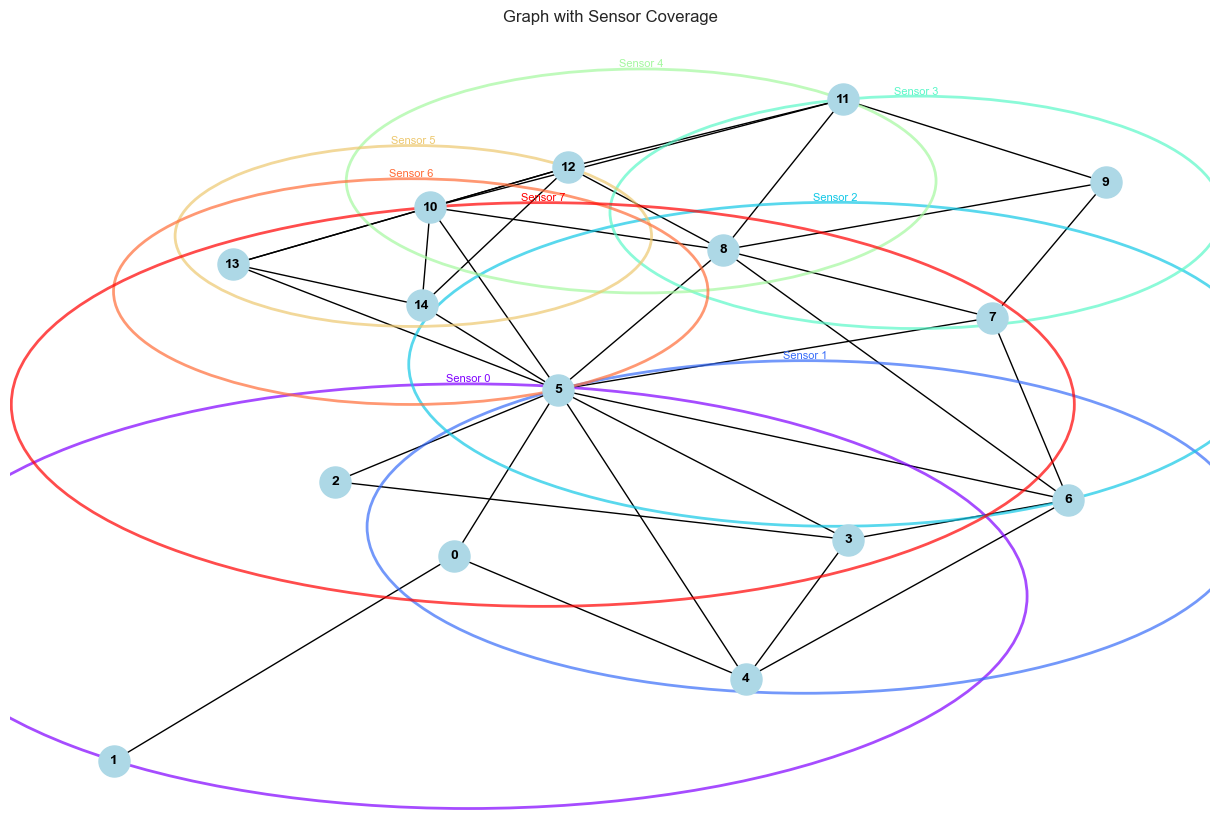

In [190]:
draw_graph_with_sensors(Gp, S)

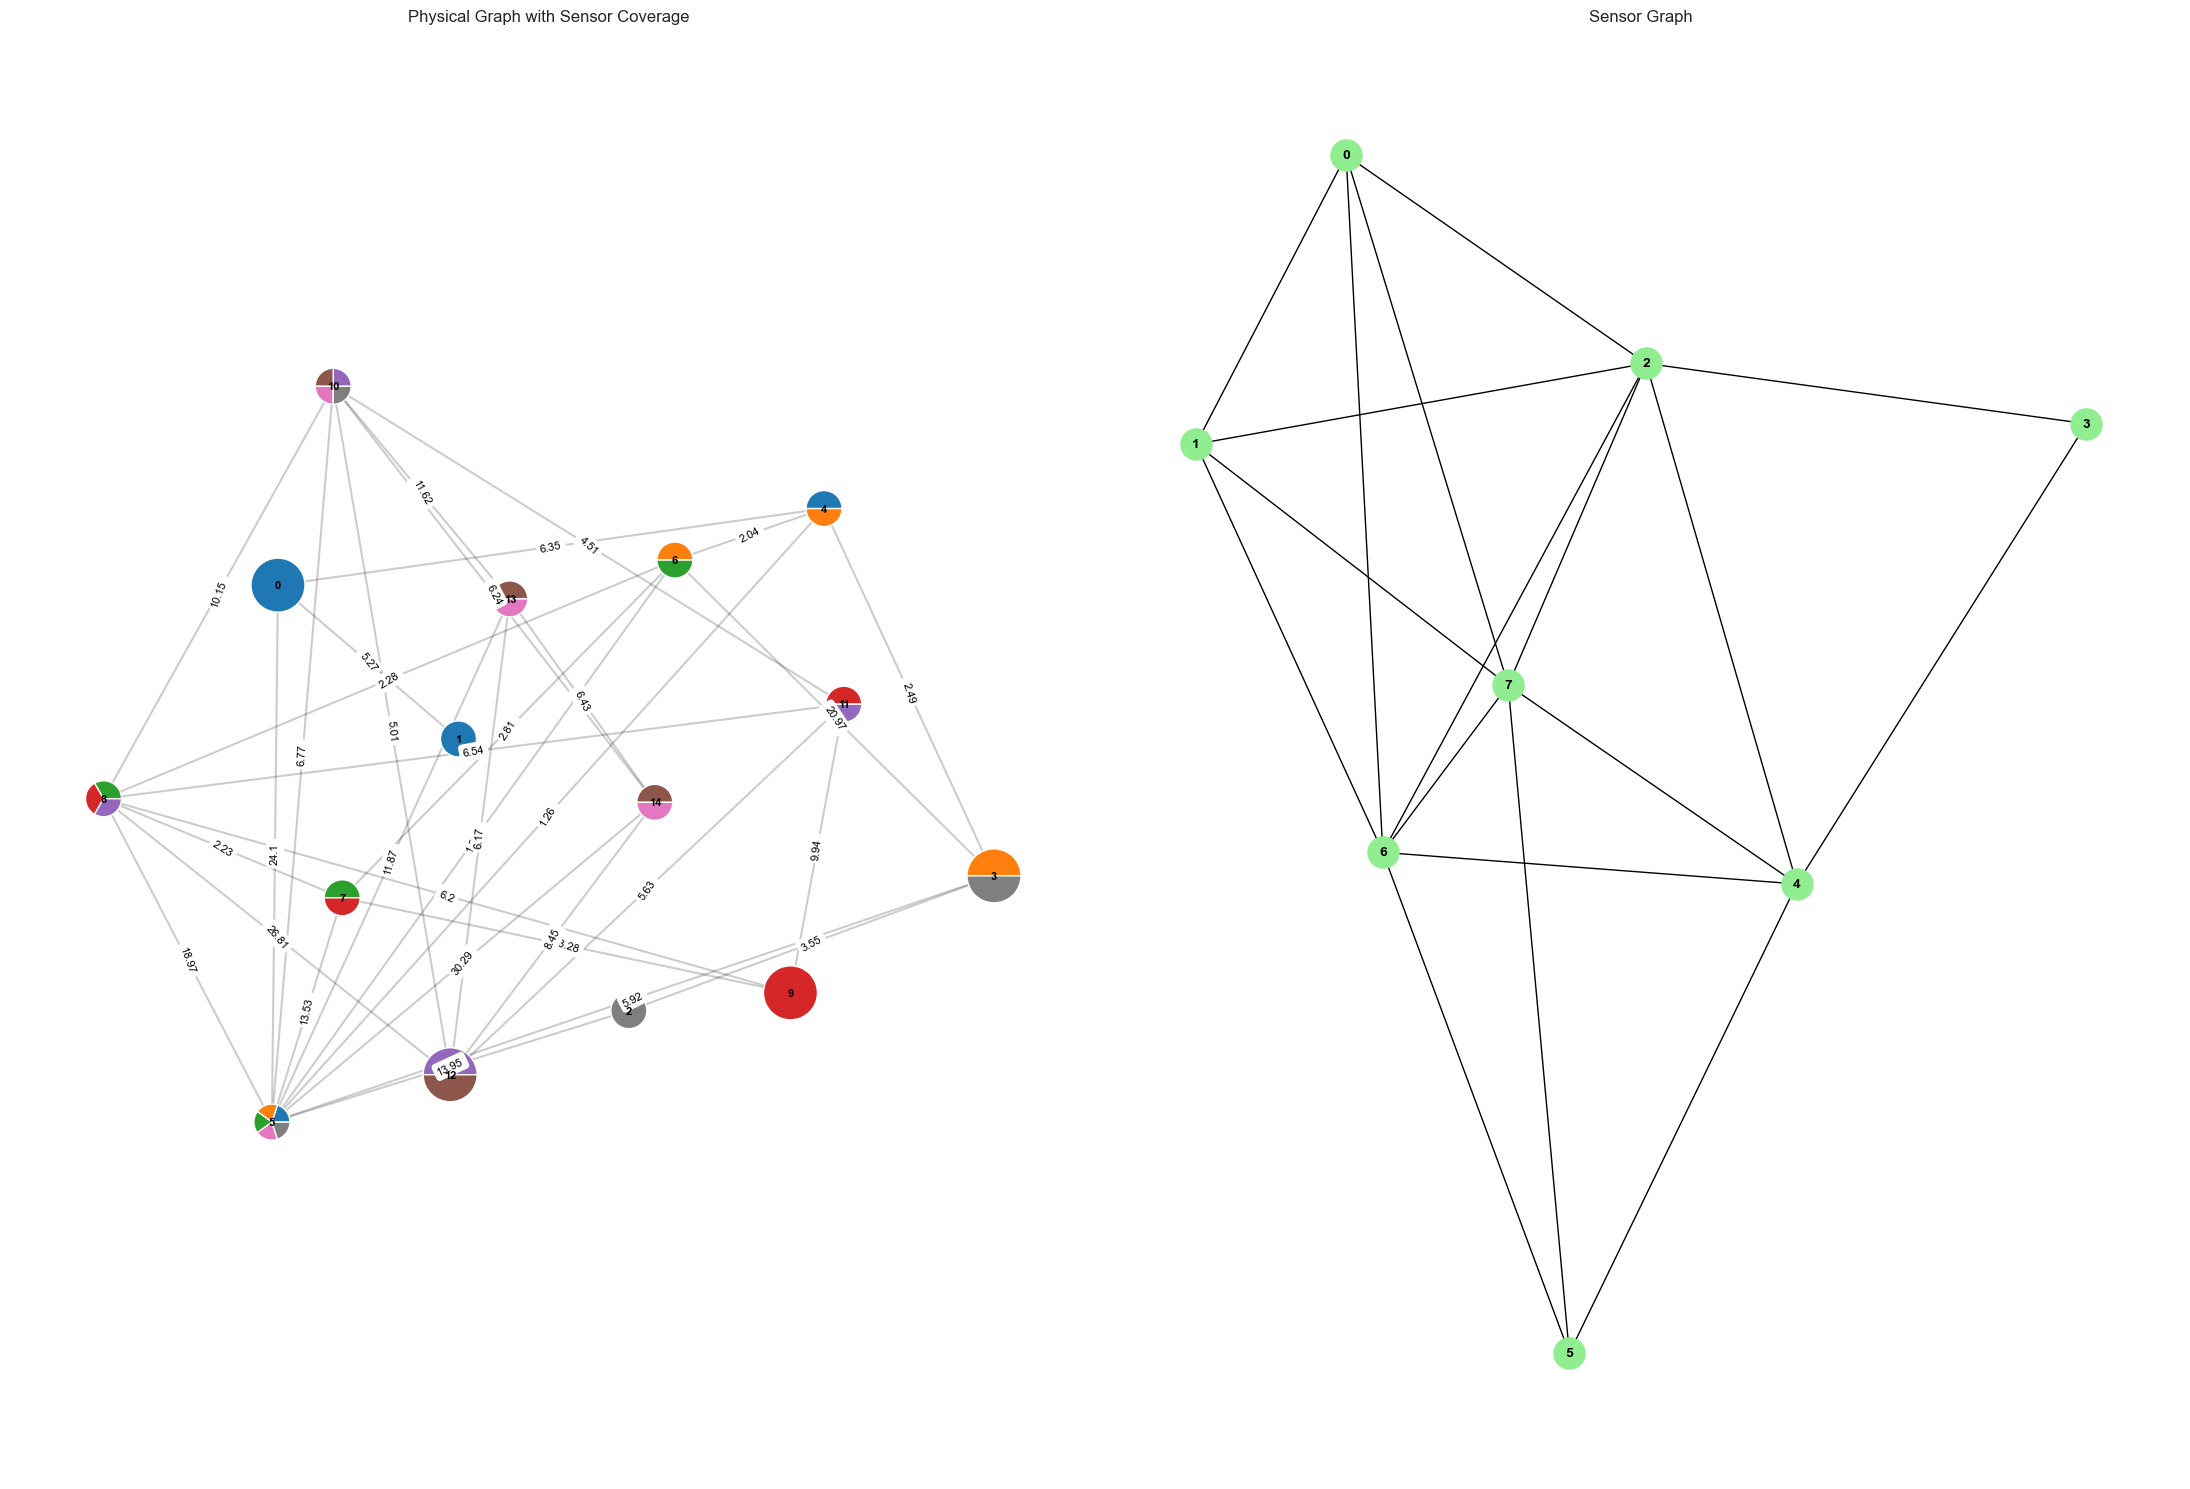

In [199]:
draw_graphs(Gp,Gs, C, S, pos)

In [192]:
path_length_weight=1
number_of_nodes_weight=1
number_of_sensors_weight=1
physical_path_deception_weight=1
sensor_path_deception_weight=1
weights=[path_length_weight,number_of_nodes_weight,number_of_sensors_weight,physical_path_deception_weight,sensor_path_deception_weight]

Path metric for physical optimized path: 2.256199304750869 0.2
Physical optimized node path: [0, 4, 6, 8, 12] Path weight: 37.48 Number of sensors: 4 0.25
Physical optimized sensor path [0, 1, 2, 4]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_99840\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


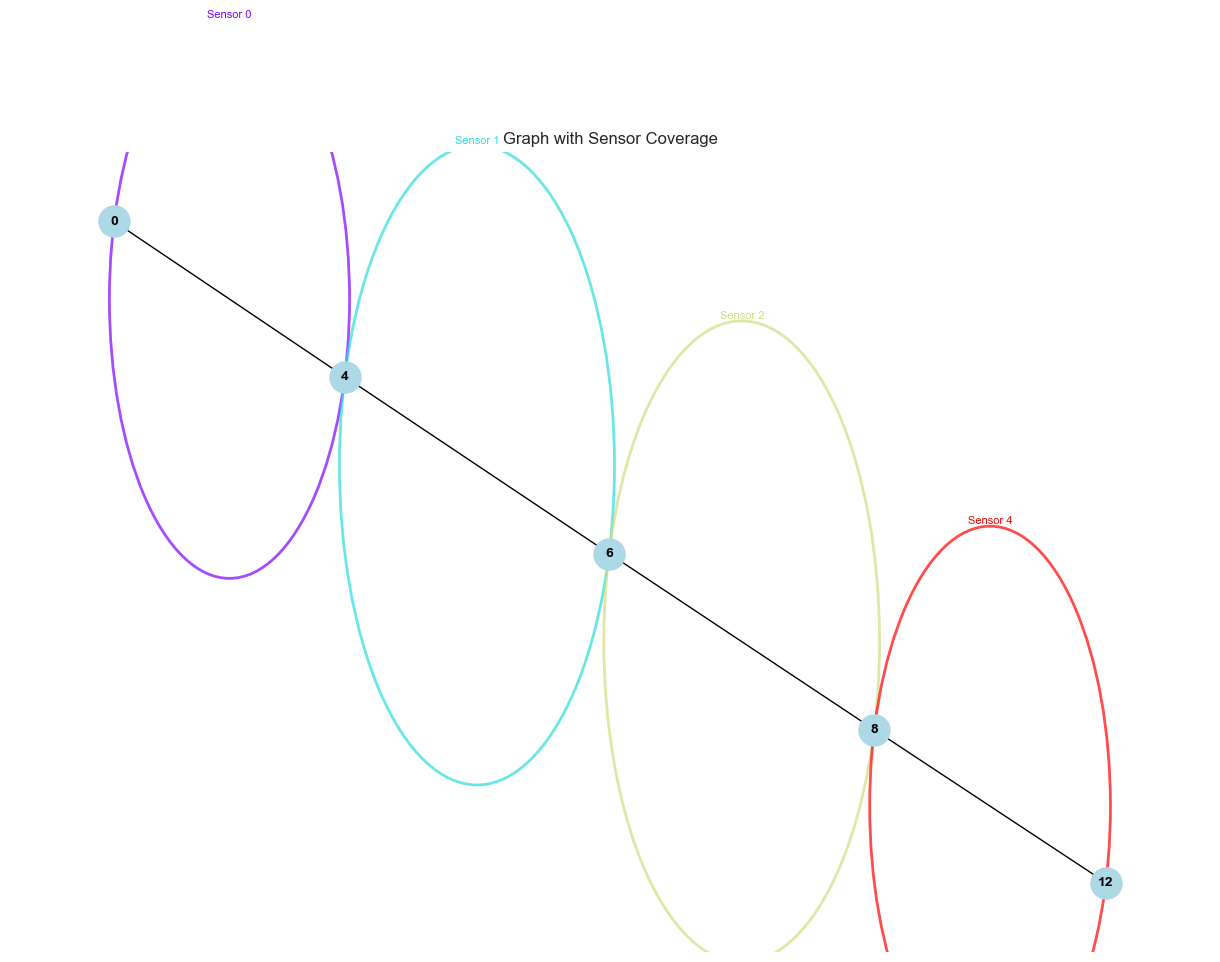

In [195]:
path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_physical_path_strategy_(Gp,0,Gs,S,target_start,Se,C,weights)
path_metric=evaluate_path_and_sensor(Gp,Gs,path_weight,complete_path,number_of_sensors,nx.diameter(Gp,weight='weight'),nx.diameter(Gs),percent_truthful_node,percent_truthful_sensor,weights,targets)
print('Path metric for physical optimized path:',path_metric,percent_truthful_node)
print('Physical optimized node path:',complete_path,'Path weight:',path_weight,'Number of sensors:',number_of_sensors,percent_truthful_sensor)
print('Physical optimized sensor path',complete_sensor_path)
path_subgraph=nx.path_graph(complete_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in complete_sensor_path:
        new_map=set()
        for node in mapping:
            if node in complete_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)



Path metric for sensor optimized path: 2.2488586326767095 Deceptiveness 0.16666666666666666
Sensor optimized node path: [0, 4, 5, 6, 8, 12] Path weight: 38.04 Number of sensors: 3
Optimized sensor path [0, 2, 4]
Percent truthful sensor 0.3333333333333333 [1, 1, 1, 1, 1]


C:\Users\yaweh\AppData\Local\Temp\ipykernel_99840\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


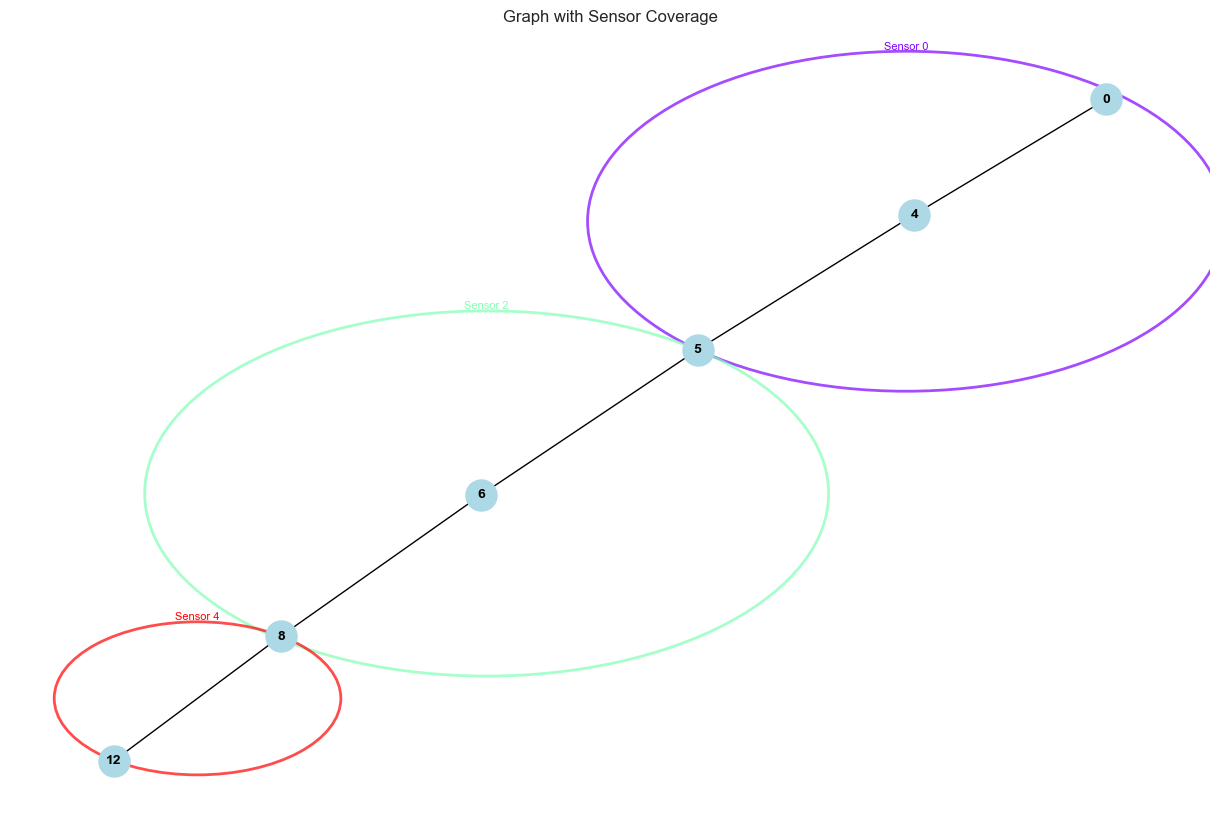

In [194]:
path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_sensor_path_strategy(Gp,Gs,0,S,Se,target_start,C)
#cost,complete_sensor_path=best_sensors_dynamic_for_path(Gp,complete_path,C,S,Se,weights)
path_metric=evaluate_path_and_sensor(Gp,Gs,path_weight,complete_path,len(complete_sensor_path),physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights,targets)
print('Path metric for sensor optimized path:',path_metric,'Deceptiveness',percent_truthful_node)
print('Sensor optimized node path:',complete_path,'Path weight:',path_weight,'Number of sensors:',number_of_sensors)
print('Optimized sensor path',complete_sensor_path)
print('Percent truthful sensor',percent_truthful_sensor,weights)
path_subgraph=nx.path_graph(complete_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in complete_sensor_path:
        new_map=set()
        for node in mapping:
            if node in complete_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

In [196]:
start_node=0
end_node=target_start
node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(Gp)
sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,S,targets)
 
to_be_removed=[]
subgraph=Gp.copy()
for node in list(subgraph.nodes):
    if (node != 0 and max_target_per_node[node][0] == target_start) or (node in targets):
        to_be_removed.append(node)
to_be_removed_sensors=[]
for sensor in list(Gs.nodes):
    if max_target_per_sensor[sensor] == target_start:
        to_be_removed_sensors.append(sensor)
shortest_distance, shortest_path= shortest_path_dynamic(Gp, Gs,start_node, end_node,S,Se, custom_distance,weights)
#fin_sensor_path,to_be_removed_sensors,sensor_and_coverage=best_sensors_for_path(shortest_path,start_node, Se, node_probabilities, S, targets, end_node,C,end_node)
cost,fin_sensor_path=best_sensors_dynamic_for_path(Gp,shortest_path,C,S,Se,weights)
if shortest_path:
    print(f"Shortest path from {start_node} to {end_node}: {shortest_path}","Sensor path:",fin_sensor_path)
    
else:
    print(f"No path exists between {start_node} and {end_node}")
percent_truthful_node=len(set(shortest_path).intersection(set(to_be_removed)))/len(set(shortest_path))
print(f'Percent truthful node:{percent_truthful_node}')
percent_truthful_sensor=len(set(fin_sensor_path).intersection(set(to_be_removed_sensors)))/max(1,len(set(fin_sensor_path)))
path_weight=nx.path_weight(Gp,shortest_path,weight='weight')
path_metric=evaluate_path_and_sensor(Gp,Gs,path_weight,shortest_path,len(fin_sensor_path),nx.diameter(Gp,weight='weight'),nx.diameter(Gs),percent_truthful_node,percent_truthful_sensor,weights,targets)

print('Path metric for joint optimized:',path_metric,percent_truthful_node,percent_truthful_sensor,path_weight)

Shortest path from 0 to 12: [0, 5, 8, 12] Sensor path: [0, 2, 4]
Percent truthful node:0.25
Path metric for joint optimized: 2.534822325222094 0.25 0.3333333333333333 69.88


C:\Users\yaweh\AppData\Local\Temp\ipykernel_99840\3974539854.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


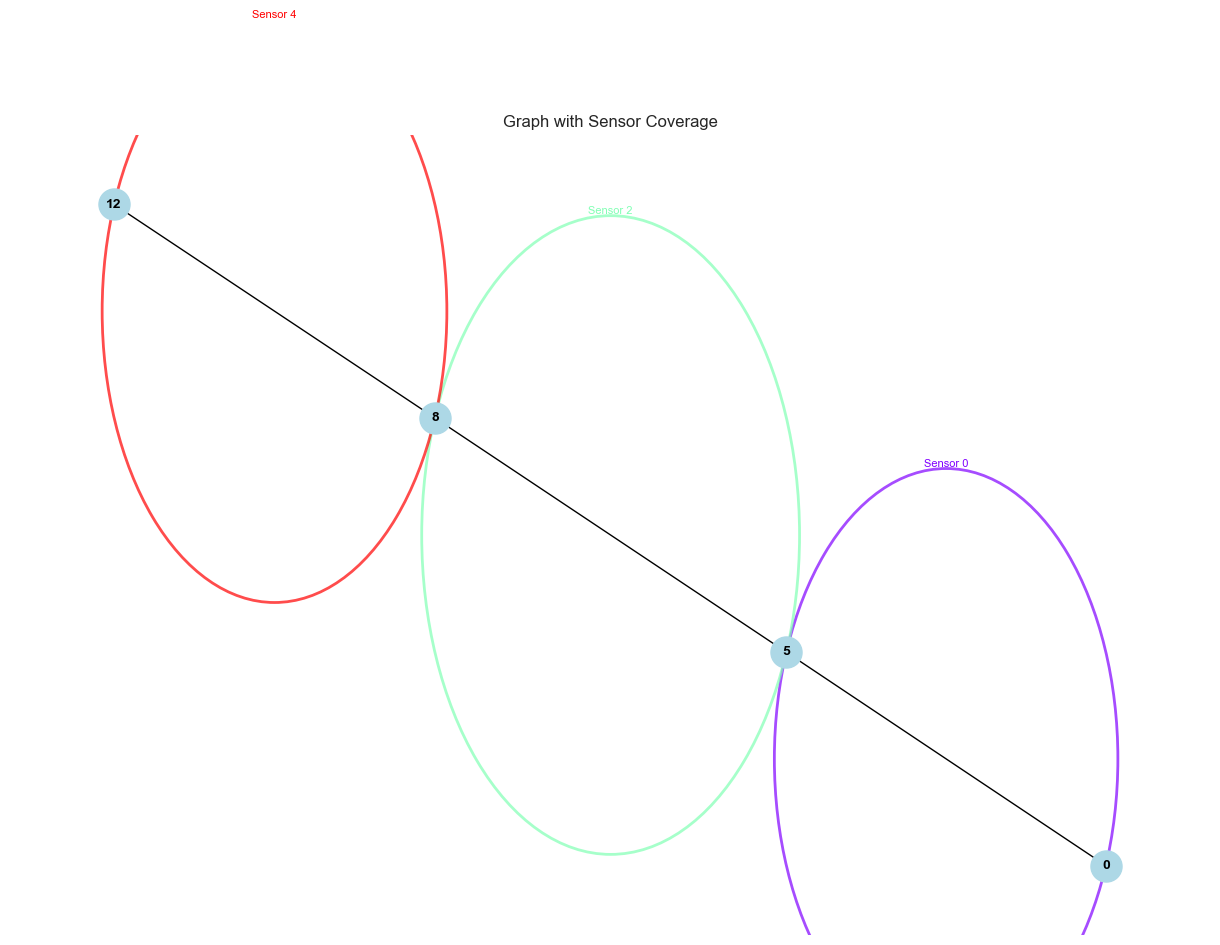

In [197]:
path_subgraph=nx.path_graph(shortest_path)
adjusted_mapping={}
for sensor,mapping in S.items():
    if sensor in fin_sensor_path:
        new_map=set()
        for node in mapping:
            if node in shortest_path:
                new_map.add(node)
        adjusted_mapping[sensor]=new_map
        
draw_graph_with_sensors(path_subgraph, adjusted_mapping)

In [198]:
brute_force_path_strategy(Gp,0,Gs,S,Se,target_start,C,weights,False)

(2.256199304750869, [0, 4, 6, 8, 12], [0, 1, 2, 4])

In [203]:
for num_physical_nodes in tqdm(range(12,30,2)):
    holder=[['Number of nodes','Probability','Number of sensors','Number of targets','Max nodes per sensor','Sensor radius','Path length weight','Number of nodes weight','Number of sensors weight','Physical deception weight','Sensor deception weight','Physical optimized score','Sensor optimized score','Joint optimized score','Brute force score']]
    #df=pd.DataFrame(columns=holder[0])
    
    for probability in np.linspace(0.4,0.9,6):
        print(probability)
        for i in range(10):
            for num_sensors in [5,10,15]: 
                for num_targets in range(3,4):
                    for max_nodes_per_sensor in range(5,num_physical_nodes-1,3):
                        for sensor_radius in range(8,40,10):
                            
                            Gp,targets = create_physical_graph(num_physical_nodes, probability, num_targets,min_weight,max_weight)
                            for (s,t) in Gp.edges():
                                if (s==0 and t in targets) or (t==0 and s in targets):
                                   Gp.remove_edge(s,t)
                            pos = nx.spring_layout(Gp)
                            C, S, Se = create_coverage_mapping(Gp, num_sensors, sensor_radius,inter_param,max_nodes_per_sensor)
                            for (s,t) in Gp.edges():
                               if not any((s,t) in values for values in Se.values()):
                                   Gp.remove_edge(s,t)
                            Gs = create_sensor_graph(S)
                            target_start=max(targets)
    
                            for path_length_weight in range(1,10):
                                for number_of_nodes_weight in range(1,10):        
                                    for number_of_sensors_weight in range(1,10):
                                        for physical_path_deception_weight in range(1,10):
                                            for sensor_path_deception_weight in range(1,10):
                                                weights=[path_length_weight,number_of_nodes_weight,number_of_sensors_weight,physical_path_deception_weight,sensor_path_deception_weight]
                                                
                                                if Gp.has_edge(target_start,0):
                                                    subgraph.remove_edge(target_start,0)
    
    
                                                node_probabilities,max_target_per_node,targets,costs=get_node_probabilities(Gp)
                                                sensor_probabilities,max_target_per_sensor=calculate_sensor_probabilities(node_probabilities,S,targets)
    
    
                                                to_be_removed_sensors_fin=[]
                                                for sensor in list(Gs.nodes):
                                                    if max_target_per_sensor[sensor] == target_start:
                                                        to_be_removed_sensors_fin.append(sensor)
                                                to_be_removed_fin=[]
                                                for node in list(Gp.nodes):
                                                    if (node != 0 and max_target_per_node[node][0] == target_start) or (node in targets):
                                                        to_be_removed_fin.append(node)
                                                                                            
                                                path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path=best_physical_path_strategy_(Gp,0,Gs,S,target_start,Se,C,weights)
                                                
                                                physical_optimized_path_metric=evaluate_path_and_sensor(Gp,Gs,path_weight,complete_path,number_of_sensors,nx.diameter(Gp,weight='weight'),nx.diameter(Gs),percent_truthful_node,percent_truthful_sensor,weights,targets)
                                                #print('Physical results', path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,complete_path,complete_sensor_path)
                                                #print('Physical',physical_optimized_path_metric,complete_path,complete_sensor_path,weights)
                                                
                                                path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,sensor_node_path,complete_sensor_path=best_sensor_path_strategy(Gp,Gs,0,S,Se,target_start,C)
                                                
                                                #print('Sensor results',path_weight,number_of_sensors,physical_diameter,sensor_diameter,percent_truthful_node ,percent_truthful_sensor,sensor_node_path,complete_sensor_path)
                                                
                                                sensor_optimized_path_metric=evaluate_path_and_sensor(Gp,Gs,path_weight,sensor_node_path,len(complete_sensor_path),physical_diameter,sensor_diameter,percent_truthful_node,percent_truthful_sensor,weights,targets)
                                                #print('Sensor',sensor_optimized_path_metric,sensor_node_path,complete_sensor_path,weights)
                                                
                                                
                                                shortest_distance, shortest_path = shortest_path_dynamic(Gp, Gs,0, target_start,S,Se, custom_distance,weights)
                                                if len(shortest_path)<2:
                                                    print(shortest_path)
                                                cost,fin_sensor_path=best_sensors_dynamic_for_path(Gp,shortest_path,C,S,Se,weights)
                                                percent_truthful_node=len(set(shortest_path).intersection(set(to_be_removed_fin)))/max(1,len(set(shortest_path)))
                                                percent_truthful_sensor=len(set(fin_sensor_path).intersection(set(to_be_removed_sensors_fin)))/max(1,len(set(fin_sensor_path)))
                
                                                path_weight=nx.path_weight(Gp,shortest_path,weight='weight')
                                                joint_optimized_path_matric=evaluate_path_and_sensor(Gp,Gs,path_weight,shortest_path,len(fin_sensor_path),nx.diameter(Gp,weight='weight'),nx.diameter(Gs),percent_truthful_node,percent_truthful_sensor,weights,targets)
                                                
                                                if num_physical_nodes<=14:
                                                    if num_physical_nodes+number_of_sensors<=25:
                                                        brute_force_path_metric,brute_path,brute_sensors=brute_force_path_strategy(Gp,0,Gs,S,Se,target_start,C,weights,False)
                                                        #print('Brute force passed',brute_path,brute_sensors,brute_force_path_metric,weights)
                                                else:
                                                    brute_force_path_metric=0
                                                data=[num_physical_nodes,probability,num_sensors,num_targets,max_nodes_per_sensor,sensor_radius,path_length_weight,number_of_nodes_weight,number_of_sensors_weight,physical_path_deception_weight,sensor_path_deception_weight,physical_optimized_path_metric,sensor_optimized_path_metric,joint_optimized_path_matric,brute_force_path_metric]
                                                
                                                #df = df.append(pd.Series(data, index=df.columns), ignore_index=True)
                                                holder.append(data)
                                                break
                                            break
                                        break
                                    break
                                break
                            break
                        break
                    break
                
    df = pd.DataFrame(holder[1:], columns=holder[0])
    df.to_csv(f'Variation-{num_physical_nodes}+ Sensors varied.csv')
    print('Physical csv written successfully!',num_physical_nodes,'nodes')                                                                                

#print('Physical:',physical_optimized_path_metric,'Sensor:',sensor_optimized_path_metric,'Joint',joint_optimized_path_matric,'Brute(optimal)',brute_force_path_metric)


  0%|          | 0/9 [00:00<?, ?it/s]

0.4


  0%|          | 0/9 [00:50<?, ?it/s]


KeyboardInterrupt: 

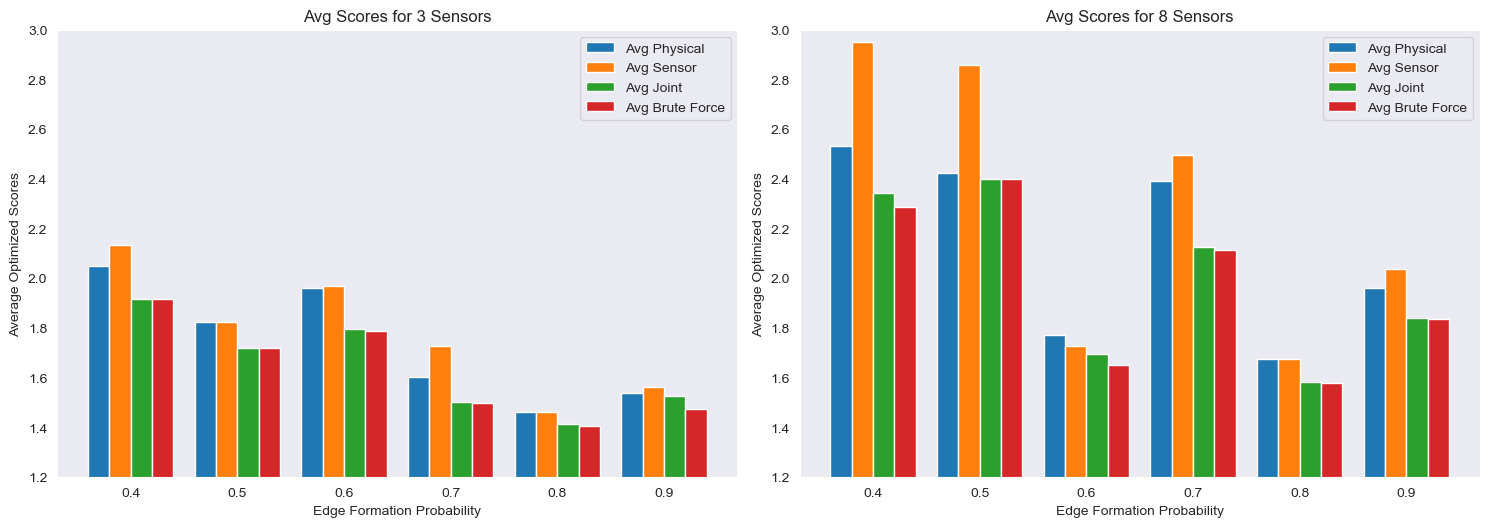

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv('Variation-28+ Sensors varied.csv')

# Exclude rows where brute force has a value of inf
data = data[data['Brute force score'] != np.inf]
data['Probability'] = data['Probability'].round(2)
# Exclude rows where any of the strategies have a score of 20
data = data[(data['Physical optimized score'] < 20) & 
            (data['Sensor optimized score'] < 20) & 
            (data['Joint optimized score'] < 20) & 
            (data['Brute force score'] < 20)]

# Get the unique number of sensors
unique_sensors = data['Number of sensors'].unique()

# Input y-axis limits and step size
y_start = float(1.2)
y_step = float(0.02)
y_max = float(3.0)

# Set up the figure for bar plots
plt.figure(figsize=(15, 10))

# Create bar and box plots for each number of sensors
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Calculate average scores by edge formation probability
    average_scores = filtered_data.groupby('Probability').agg({
        'Physical optimized score': 'mean',
        'Sensor optimized score': 'mean',
        'Joint optimized score': 'mean',
        'Brute force score': 'mean'
    }).reset_index()
    
    # Bar chart for average scores
    bar_width = 0.20
    x = range(len(average_scores))
    
    # Create bars for each strategy
    plt.bar(x, average_scores['Physical optimized score'], width=bar_width, label='Avg Physical', align='center')
    plt.bar([p + bar_width for p in x], average_scores['Sensor optimized score'], width=bar_width, label='Avg Sensor', align='center')
    plt.bar([p + bar_width * 2 for p in x], average_scores['Joint optimized score'], width=bar_width, label='Avg Joint', align='center')
    #plt.bar([p + bar_width * 3 for p in x], average_scores['Brute force score'], width=bar_width, label='Avg Brute Force', align='center')
    
    # Set labels and title for the bar plot
    plt.title(f'Avg Scores for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Average Optimized Scores')
    plt.xticks([p + bar_width * 1.5 for p in x], average_scores['Probability'])
    plt.legend()
    
    # Set y-axis limits and ticks
    plt.ylim(y_start, y_max)
    #plt.yticks(np.arange(y_start, y_max + y_step, y_step))
    plt.grid()

# Adjust layout for bar plots
plt.tight_layout()
plt.show()

# Set up the figure for box plots
plt.figure(figsize=(15, 10))

# Create box plots for each number of sensors


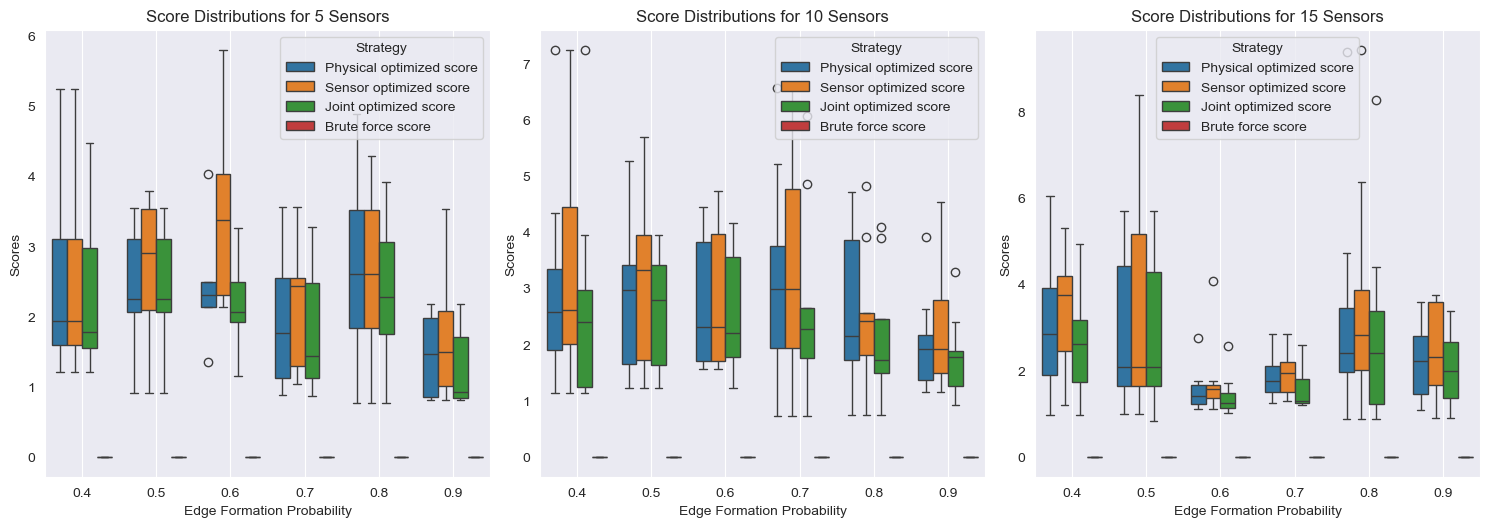

In [164]:
# Set up the figure for box plots
plt.figure(figsize=(15, 10))
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Melt the data for the box plot
    melted_data = filtered_data.melt(id_vars=['Probability'], value_vars=['Physical optimized score', 'Sensor optimized score', 'Joint optimized score', 'Brute force score'],
                                      var_name='Strategy', value_name='Score')
    
    # Create the box plot
    sns.boxplot(x='Probability', y='Score', hue='Strategy', data=melted_data)
    plt.title(f'Score Distributions for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Scores')
    
    # Set y-axis limits and ticks
    #plt.ylim(y_start, y_max)
    #plt.yticks(np.arange(y_start, y_max + y_step, y_step))
    
    plt.legend(title='Strategy')
    plt.grid()

# Adjust layout for box plots
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv('Variation-14+ Sensors varied.csv')

# Exclude rows where brute force has a value of inf
data = data[data['Brute force score'] != np.inf]

# Exclude rows where any of the strategies have a score of 20
data = data[(data['Physical optimized score'] < 20) & 
            (data['Sensor optimized score'] < 20) & 
            (data['Joint optimized score'] < 20) & 
            (data['Brute force score'] < 20)]

# Exclude rows where joint optimized score is less than brute force score
data = data[data['Joint optimized score'] >= data['Brute force score']]
data = data[data['Physical optimized score'] >= data['Brute force score']]

# Get the unique number of sensors
unique_sensors = data['Number of sensors'].unique()

# Set up the figure for bar plots
plt.figure(figsize=(15, 10))

# Create bar and box plots for each number of sensors
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Calculate average scores by edge formation probability
    average_scores = filtered_data.groupby('Probability').agg({
        'Physical optimized score': 'mean',
        'Sensor optimized score': 'mean',
        'Joint optimized score': 'mean',
        'Brute force score': 'mean'
    }).reset_index()
    
    # Bar chart for average scores
    bar_width = 0.20
    x = range(len(average_scores))
    
    # Create bars for each strategy
    plt.bar(x, average_scores['Physical optimized score'], width=bar_width, label='Avg Physical', align='center')
    plt.bar([p + bar_width for p in x], average_scores['Sensor optimized score'], width=bar_width, label='Avg Sensor', align='center')
    plt.bar([p + bar_width * 2 for p in x], average_scores['Joint optimized score'], width=bar_width, label='Avg Joint', align='center')
    plt.bar([p + bar_width * 3 for p in x], average_scores['Brute force score'], width=bar_width, label='Avg Brute Force', align='center')
    
    # Set labels and title for the bar plot
    plt.title(f'Avg Scores for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Average Optimized Scores')
    plt.xticks([p + bar_width * 1.5 for p in x], average_scores['Probability'])
    plt.legend()
    plt.grid()

# Adjust layout for bar plots
plt.tight_layout()
plt.show()

# Set up the figure for box plots
plt.figure(figsize=(15, 10))

# Create box plots for each number of sensors
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Melt the data for the box plot
    melted_data = filtered_data.melt(id_vars=['Probability'], value_vars=['Physical optimized score', 'Sensor optimized score', 'Joint optimized score', 'Brute force score'],
                                      var_name='Strategy', value_name='Score')
    
    # Create the box plot
    sns.boxplot(x='Probability', y='Score', hue='Strategy', data=melted_data)
    plt.title(f'Score Distributions for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Scores')
    plt.legend(title='Strategy')
    plt.grid()

# Adjust layout for box plots
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
data = pd.read_csv('Variation-12+ Sensors varied.csv')

# Exclude rows where brute force has a value of inf
data = data[data['Brute force score'] != np.inf]

# Exclude rows where any of the strategies have a score of 20
data = data[(data['Physical optimized score'] < 20) & 
            (data['Sensor optimized score'] < 20) & 
            (data['Joint optimized score'] < 20) & 
            (data['Brute force score'] < 20)]

# Exclude rows where joint optimized score is less than brute force score
data = data[data['Joint optimized score'] >= data['Brute force score']]
data = data[data['Physical optimized score'] >= data['Brute force score']]
# Scale up the scores for better visibility
scaling_factor = 10000
data['Physical optimized score'] *= scaling_factor
data['Sensor optimized score'] *= scaling_factor
data['Joint optimized score'] *= scaling_factor
data['Brute force score'] *= scaling_factor

# Get the unique number of sensors
unique_sensors = data['Number of sensors'].unique()

# Set up the figure for bar plots
plt.figure(figsize=(15, 10))

# Create bar and box plots for each number of sensors
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Calculate average scores by edge formation probability
    average_scores = filtered_data.groupby('Probability').agg({
        'Physical optimized score': 'mean',
        'Sensor optimized score': 'mean',
        'Joint optimized score': 'mean',
        'Brute force score': 'mean'
    }).reset_index()
    
    # Bar chart for average scores
    bar_width = 0.20
    x = range(len(average_scores))
    
    # Create bars for each strategy
    plt.bar(x, average_scores['Physical optimized score'], width=bar_width, label='Avg Physical', align='center')
    plt.bar([p + bar_width for p in x], average_scores['Sensor optimized score'], width=bar_width, label='Avg Sensor', align='center')
    plt.bar([p + bar_width * 2 for p in x], average_scores['Joint optimized score'], width=bar_width, label='Avg Joint', align='center')
    plt.bar([p + bar_width * 3 for p in x], average_scores['Brute force score'], width=bar_width, label='Avg Brute Force', align='center')
    
    # Set labels and title for the bar plot
    plt.title(f'Avg Scores for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Average Optimized Scores (Scaled)')
    plt.xticks([p + bar_width * 1.5 for p in x], average_scores['Probability'])
    plt.legend()
    plt.grid()

# Adjust layout for bar plots
plt.tight_layout()
plt.show()

# Set up the figure for box plots
plt.figure(figsize=(15, 10))

# Create box plots for each number of sensors
for i, num_sensors in enumerate(unique_sensors):
    plt.subplot(2, len(unique_sensors), i + 1)
    
    # Filter data for the current number of sensors
    filtered_data = data[data['Number of sensors'] == num_sensors]
    
    # Melt the data for the box plot
    melted_data = filtered_data.melt(id_vars=['Probability'], value_vars=['Physical optimized score', 'Sensor optimized score', 'Joint optimized score', 'Brute force score'],
                                      var_name='Strategy', value_name='Score')
    
    # Create the box plot
    sns.boxplot(x='Probability', y='Score', hue='Strategy', data=melted_data)
    plt.title(f'Score Distributions for {num_sensors} Sensors')
    plt.xlabel('Edge Formation Probability')
    plt.ylabel('Scores (Scaled)')
    plt.legend(title='Strategy')
    plt.grid()

# Adjust layout for box plots
plt.tight_layout()
plt.show()